# Part II (Swaption Calibration)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from scipy import interpolate
import matplotlib.pylab as plt
from matplotlib.pyplot import subplot
from scipy.optimize import least_squares

In [2]:
# Black Model

def BlackCall(S, K, discount_factor, sigma, T):
    d1 = (np.log(S / K) + (sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return discount_factor * (S * norm.cdf(d1) - K * norm.cdf(d2))

def BlackPut(S, K, discount_factor, sigma, T):
    d1 = (np.log(S / K) + (sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return discount_factor * (K * norm.cdf(-d2) - S * norm.cdf(-d1))

In [3]:
# Payer and Receiver IV

def impliedCallVolatility(S, K, discount_factor, price, T):
    impliedVol = brentq(lambda x: price -
                    BlackCall(S, K, discount_factor, x, T),
                    1e-6, 10)
    
    return impliedVol

def impliedPutVolatility(S, K, discount_factor, price, T):
    impliedVol = brentq(lambda x: price -
                    BlackPut(S, K, discount_factor, x, T),
                    1e-6, 10)
    
    return impliedVol

In [4]:
# DataFrame Import

swaption = pd.read_excel('IR Data.xlsx', sheet_name = 'Swaption', header = 2)
forward_swap = pd.read_csv('Forward_Swap_Rate.csv')
discount_factors = pd.read_csv('All_DFs.csv')

In [5]:
expiries = forward_swap['Expiry/Tenor'].values
tenor = [col for col in forward_swap.columns if col != 'Expiry/Tenor']
forward_swap_rates = pd.DataFrame()

# Reformating forward swap df 
for t in tenor:
    temp = pd.DataFrame()
    temp['Expiry'] = expiries
    temp['Tenor'] = t
    temp['Rate'] = forward_swap[t]

    forward_swap_rates = pd.concat([forward_swap_rates, temp])

forward_swap_rates['Expiry'] = forward_swap_rates['Expiry'].str.replace('y', '').astype(int)
forward_swap_rates['Tenor'] = forward_swap_rates['Tenor'].str.replace('y', '').str.replace('X','').astype(int) 
forward_swap_rates['PVBP'] = 0

# compute the PVBP discount factor for each swap
for row in range(len(forward_swap_rates)):
    expiry = forward_swap_rates['Expiry'].iloc[row , ]
    tenor = forward_swap_rates['Tenor'].iloc[row , ]
    forward_swap_rates['PVBP'].iloc[row, ] = 0.5 * discount_factors['OIS DF'].iloc[expiry * 2 : expiry * 2 + tenor * 2, ].sum()

calibration_expiries = [1, 5, 10]
forward_swap_rates_calibration = forward_swap_rates[forward_swap_rates['Expiry'].isin(calibration_expiries)]

forward_swap_rates_calibration = forward_swap_rates_calibration.sort_values(by = ['Expiry', 'Tenor'])

forward_swap_rates_calibration

C:\Users\Edmund\AppData\Local\Temp\ipykernel_27196\1602674000.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_swap_rates['PVBP'].iloc[row, ] = 0.5 * discount_factors['OIS DF'].iloc[expiry * 2 : expiry * 2 + tenor * 2, ].sum()


,Expiry,Tenor,Rate,PVBP
0,1,1,0.032007,0.994400
0,1,2,0.033259,1.985294
0,1,3,0.034011,2.972386
0,1,5,0.035255,4.934070
0,1,10,0.038428,9.747887
2,5,1,0.039274,0.978517
2,5,2,0.040075,1.952145
2,5,3,0.040072,2.920444
2,5,5,0.041093,4.840612
2,5,10,0.043634,9.542492


In [6]:
swaption = swaption.iloc[0:15,0:13]
swaption.iloc[:, 2:] = swaption.iloc[:, 2:] / 100 # convert swaption rates to %
swaption['Expiry'] = swaption['Expiry'].str.replace('Y','').astype(int)
swaption['Tenor'] = swaption['Tenor'].str.replace('Y','').astype(int)

In [7]:
swaption

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1,1,0.91570,0.62030,0.44130,0.31224,0.26182,0.2250,0.2096,0.2140,0.2434,0.27488,0.30297
1,1,2,0.83270,0.61240,0.46570,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523
2,1,3,0.73920,0.56870,0.44770,0.35745,0.32317,0.2978,0.2829,0.2780,0.2877,0.30725,0.32833
3,1,5,0.55190,0.44640,0.36510,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165
4,1,10,0.41180,0.35040,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355
5,5,1,0.67800,0.49090,0.38400,0.31485,0.29060,0.2726,0.2604,0.2532,0.2494,0.25320,0.25980
6,5,2,0.57880,0.46410,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.26540,0.26760
7,5,3,0.53430,0.44440,0.38180,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.26200,0.26150
8,5,5,0.41990,0.36524,0.32326,0.29005,0.27677,0.2660,0.2573,0.2502,0.2406,0.23570,0.23400
9,5,10,0.34417,0.30948,0.28148,0.25954,0.25136,0.2451,0.2399,0.2356,0.2291,0.22490,0.22250


In [8]:
# Retrieve basis points delta from ATM rates
basis_points = [0 if i == 'ATM' else float(i.replace('bps', '')) / 10000 for i in swaption.columns[2 : ]]

# Create df of strikes for each swaption
strikes = swaption.copy()
for i in range(len(strikes)):
    strikes.iloc[i , 2:] = basis_points + forward_swap_rates_calibration['Rate'].iloc[i]

strikes

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1,1,0.012007,0.017007,0.022007,0.027007,0.029507,0.032007,0.034507,0.037007,0.042007,0.047007,0.052007
1,1,2,0.013259,0.018259,0.023259,0.028259,0.030759,0.033259,0.035759,0.038259,0.043259,0.048259,0.053259
2,1,3,0.014011,0.019011,0.024011,0.029011,0.031511,0.034011,0.036511,0.039011,0.044011,0.049011,0.054011
3,1,5,0.015255,0.020255,0.025255,0.030255,0.032755,0.035255,0.037755,0.040255,0.045255,0.050255,0.055255
4,1,10,0.018428,0.023428,0.028428,0.033428,0.035928,0.038428,0.040928,0.043428,0.048428,0.053428,0.058428
5,5,1,0.019274,0.024274,0.029274,0.034274,0.036774,0.039274,0.041774,0.044274,0.049274,0.054274,0.059274
6,5,2,0.020075,0.025075,0.030075,0.035075,0.037575,0.040075,0.042575,0.045075,0.050075,0.055075,0.060075
7,5,3,0.020072,0.025072,0.030072,0.035072,0.037572,0.040072,0.042572,0.045072,0.050072,0.055072,0.060072
8,5,5,0.021093,0.026093,0.031093,0.036093,0.038593,0.041093,0.043593,0.046093,0.051093,0.056093,0.061093
9,5,10,0.023634,0.028634,0.033634,0.038634,0.041134,0.043634,0.046134,0.048634,0.053634,0.058634,0.063634


## Displaced Diffusion Model Calibration

In [9]:
# Displaced-Diffusion Model

def DisplacedDiffusionCall(F, K, discount_factor, sigma, T, beta):
    d1 = (np.log(F / beta / (K + ((1 - beta) / beta) * F)) + ((sigma * beta) ** 2 / 2) * T) / ((sigma * beta) * np.sqrt(T))
    d2 = d1 - (sigma * beta) * np.sqrt(T)
    return discount_factor * (F / beta * norm.cdf(d1) - (K + ((1 - beta) / beta) * F) * norm.cdf(d2))

def DisplacedDiffusionPut(F, K, discount_factor, sigma, T, beta):
    d1 = (np.log(F / beta / (K + ((1 - beta) / beta) * F)) + ((sigma * beta) ** 2 / 2) * T) / ((sigma * beta) * np.sqrt(T))
    d2 = d1 - (sigma * beta) * np.sqrt(T)
    return discount_factor * ((K + ((1 - beta) / beta) * F) * norm.cdf(-d2) - F / beta * norm.cdf(-d1))

In [10]:
def ddcalibration(x, S, strikes, discount_factor, vols, T):
    err = 0.0
    for i, vol in enumerate(vols):
        price = DisplacedDiffusionCall(S, strikes[i], discount_factor, x[0], T, x[1])
        err += (vol - impliedCallVolatility(S, strikes[i], discount_factor, price, T))**2
        
    return err

# empty array to store calibrated parameters
n_swaption = len(swaption)
dd_sigma = np.zeros(n_swaption)
dd_beta = np.zeros(n_swaption)

dd_calibration_df = swaption.copy()

initialGuess = [0.1, 0.1]

# for each swaption, run least squares calibration for sigma and beta
for swaption_term in range(len(swaption)):

    swap_rate = forward_swap_rates_calibration['Rate'].iloc[swaption_term]
    strike = strikes.iloc[swaption_term, 2 : ]
    discount_factor = forward_swap_rates_calibration['PVBP'].iloc[swaption_term]
    swaption_iv = swaption.iloc[swaption_term, 2:]
    time_to_maturity = swaption.iloc[swaption_term, 0]

    res = least_squares(lambda x: ddcalibration(x,
                                                swap_rate, # from q1
                                                strike, # from swaption data
                                                discount_factor, # from q1
                                                swaption_iv, # market IV in data
                                                time_to_maturity),# expiry                                                
                        initialGuess, bounds = ((0, 0),(np.inf, 1)))
    
    dd_sigma[swaption_term] = res.x[0]
    dd_beta[swaption_term] = res.x[1]

    # After each swaption's calibration, compute the IV for each strike
    for j in range(len(swaption.columns) - 2):
        
        strike = strikes.iloc[swaption_term, j + 2]
        ATM = strikes['ATM'].iloc[swaption_term, ]
        
        # puts if strike < ATM, calls if strike > ATM
        if strike <= ATM:
            dd_put = DisplacedDiffusionPut(swap_rate, strike, discount_factor, dd_sigma[swaption_term], time_to_maturity, dd_beta[swaption_term])
            dd_iv = impliedPutVolatility(swap_rate, strike, discount_factor, dd_put, time_to_maturity)

        elif strike > ATM:
            dd_call = DisplacedDiffusionCall(swap_rate, strike, discount_factor, dd_sigma[swaption_term], time_to_maturity, dd_beta[swaption_term])
            dd_iv = impliedCallVolatility(swap_rate, strike, discount_factor, dd_call, time_to_maturity)

        dd_calibration_df.iloc[swaption_term, j + 2] = dd_iv

dd_calibration_df['sigma'] = dd_sigma
dd_calibration_df['beta'] = dd_beta

# Formatting for presentation
dd_calibration_sigma = dd_calibration_df.pivot_table(columns  = 'Tenor', index = 'Expiry', values = 'sigma')
dd_calibration_beta = dd_calibration_df.pivot_table(columns  = 'Tenor', index = 'Expiry', values = 'beta')

In [11]:
print('Displaced Diffusion Calibrated')
print('Sigma')
display(dd_calibration_sigma)
print('Beta')
display(dd_calibration_beta)

Displaced Diffusion Calibrated
Sigma


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.366253,0.387486,0.372247,0.308648,0.269372
5,0.328454,0.327841,0.319565,0.276371,0.248764
10,0.308415,0.306062,0.301556,0.271004,0.244859


Beta


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.000157,0.001284,0.004330,0.049466,0.093889
5,0.005875,0.026401,0.040892,0.098219,0.096491
10,0.047879,0.083269,0.104070,0.083863,0.080062


# SABR Calibration

In [12]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta) ** 2) / 24) * alpha * alpha / (F ** (2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha / (F ** (1 - beta))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T) / (F ** (1 - beta))
        sabrsigma = VolAtm
    else:
        z = (nu / alpha) * ((F * X) ** (0.5 * (1 - beta))) * np.log(F / X)
        zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))
        numer1 = (((1 - beta) ** 2) / 24) * ((alpha * alpha) / ((F * X) ** (1 - beta)))
        numer2 = 0.25 * rho * beta * nu * alpha / ((F * X) ** ((1 - beta) / 2))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
        denom1 = ((1 - beta) ** 2 / 24) * (np.log(F / X)) ** 2
        denom2 = (((1 - beta) ** 4) / 1920) * ((np.log(F / X)) ** 4)
        denom = ((F * X) ** ((1 - beta) / 2)) * (1 + denom1 + denom2) * zhi
        sabrsigma = numer / denom

    return sabrsigma

In [13]:
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

beta = 0.9 # per question

n_swaption = len(swaption)

# empty array to store calibrated parameters
SABR_alpha = np.zeros(n_swaption)
SABR_nu = np.zeros(n_swaption)
SABR_rho = np.zeros(n_swaption)

SABR_calibration_df = swaption.copy()

# for each swaption, run least squares calibration for alpha, nu and rho
for swaption_term in range(len(swaption)):
    
    swap_rate = forward_swap_rates_calibration['Rate'].iloc[swaption_term]
    strike = strikes.iloc[swaption_term, 2 : ]
    discount_factor = forward_swap_rates_calibration['PVBP'].iloc[swaption_term]
    swaption_iv = swaption.iloc[swaption_term, 2:]
    time_to_maturity = swaption.iloc[swaption_term, 0]

    initialGuess = [0.2, -0.5, 1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                 strike,
                                                 swaption_iv,
                                                 swap_rate,
                                                 time_to_maturity),
                        initialGuess)

    SABR_alpha[swaption_term] = res.x[0]
    SABR_rho[swaption_term] = res.x[1]
    SABR_nu[swaption_term] = res.x[2]

    # after each swaption calibration, compute the SABR IV for each strike
    for j in range(len(swaption.columns) - 2):
        SABR_calibration_df.iloc[swaption_term, j + 2] = SABR(swap_rate, 
                                                              strikes.iloc[swaption_term, j + 2], 
                                                              time_to_maturity, 
                                                              SABR_alpha[swaption_term], 
                                                              beta, 
                                                              SABR_rho[swaption_term], 
                                                              SABR_nu[swaption_term])

SABR_calibration_df['alpha'] = SABR_alpha
SABR_calibration_df['rho'] = SABR_rho
SABR_calibration_df['nu'] = SABR_nu

# Formatting 
SABR_calibration_alpha = SABR_calibration_df.pivot_table(columns  = 'Tenor', index = 'Expiry', values = 'alpha')
SABR_calibration_rho = SABR_calibration_df.pivot_table(columns  = 'Tenor', index = 'Expiry', values = 'rho')
SABR_calibration_nu = SABR_calibration_df.pivot_table(columns  = 'Tenor', index = 'Expiry', values = 'nu')


In [14]:
print('SABR Calibrated ')
print('Alpha')
display(SABR_calibration_alpha)
print('Rho')
display(SABR_calibration_rho)
print('Nu')
display(SABR_calibration_nu)

SABR Calibrated 
Alpha


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.143982,0.187771,0.199502,0.179218,0.169430
5,0.164512,0.199109,0.209917,0.186269,0.168702
10,0.177373,0.197145,0.211862,0.219876,0.183382


Rho


Tenor,1,2,3,5,10
Expiry,,,,,
1,-0.612955,-0.524232,-0.487515,-0.421273,-0.266267
5,-0.571947,-0.544660,-0.548528,-0.490431,-0.387674
10,-0.545121,-0.550069,-0.562579,-0.609293,-0.538701


Nu


Tenor,1,2,3,5,10
Expiry,,,,,
1,1.957275,1.648198,1.413209,1.053220,0.801321
5,1.316921,1.059386,0.937251,0.695962,0.571685
10,1.006202,0.931447,0.881275,0.754289,0.606138


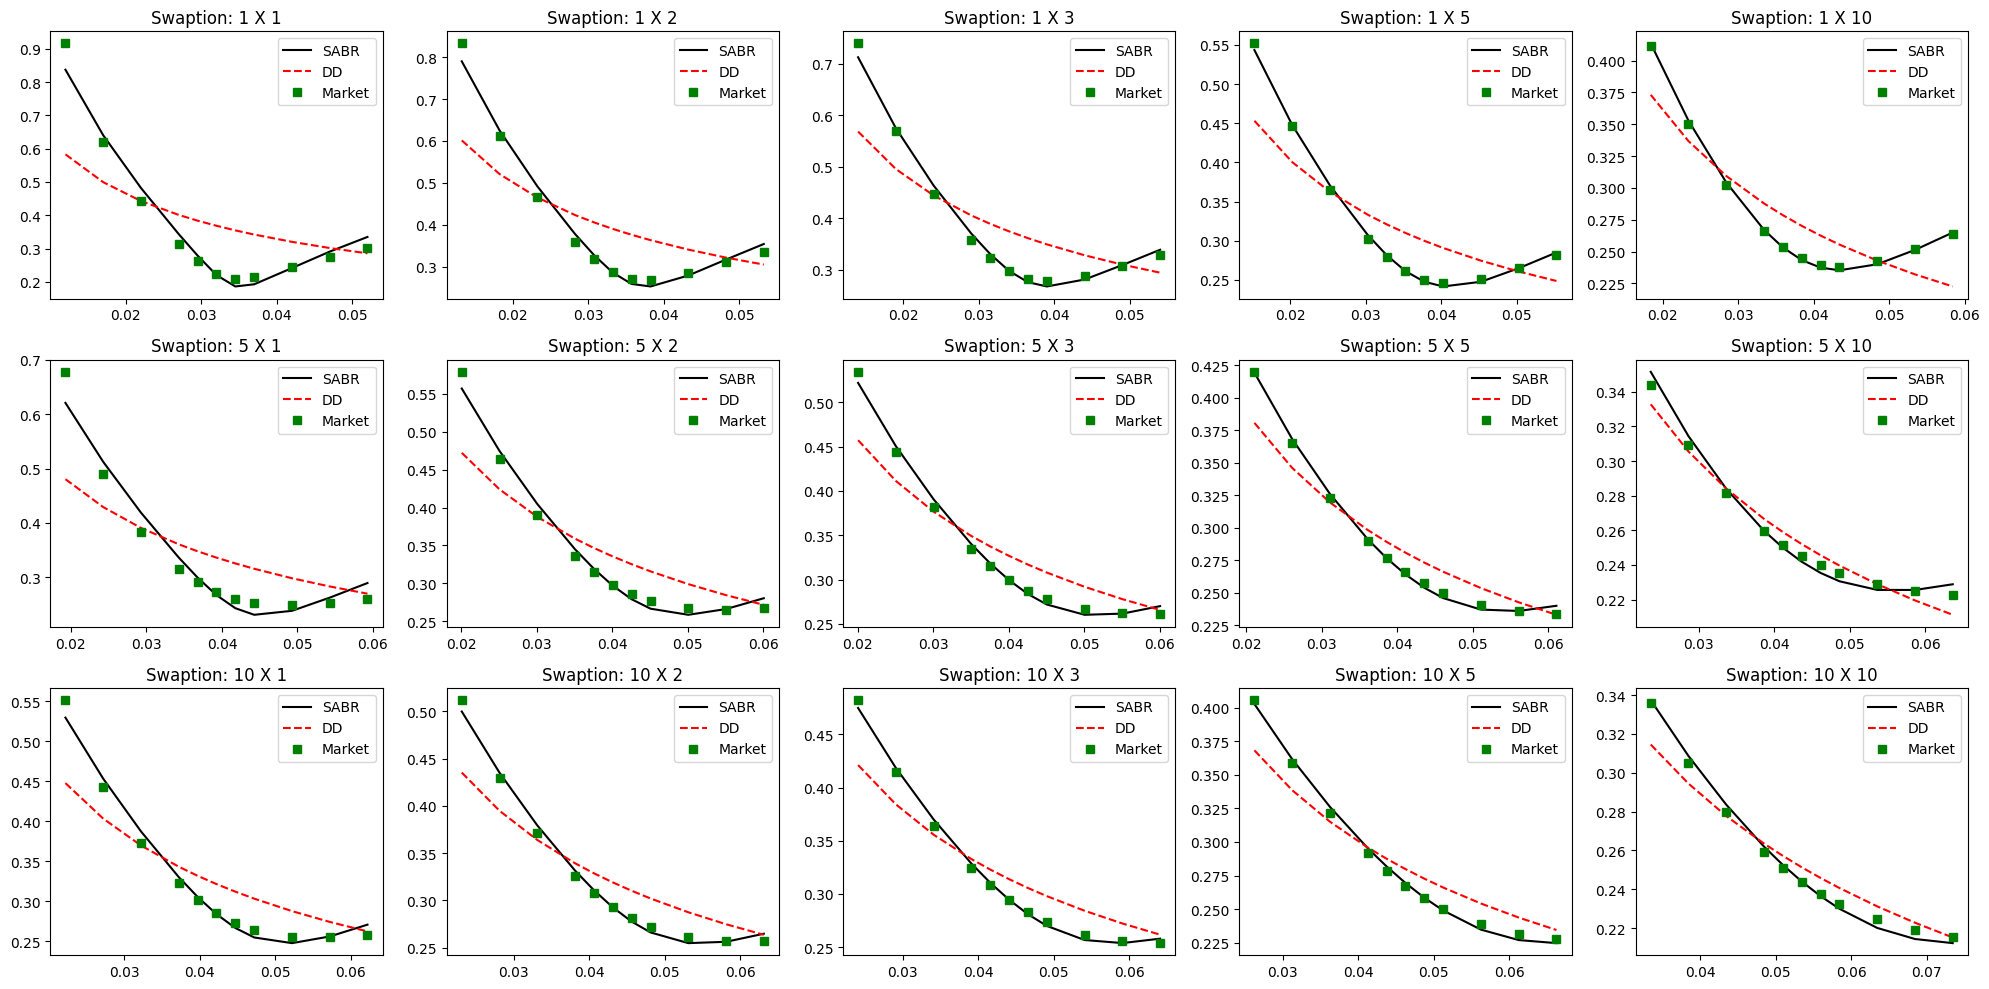

In [15]:
# Plot SABR, DD and Market
fig, axs = plt.subplots(3, 5, figsize=(20, 10), tight_layout = True)
for i, ax in enumerate(axs.flatten()):

    ax.plot(strikes.iloc[i, 2:], SABR_calibration_df.iloc[i, 2:13], 'k', label = 'SABR')
    ax.plot(strikes.iloc[i, 2:], dd_calibration_df.iloc[i, 2:13], 'r--', label = 'DD')
    ax.plot(strikes.iloc[i, 2:], swaption.iloc[i, 2:13], 'gs', label = 'Market')
    ax.set_title(f"Swaption: {strikes.loc[i, 'Expiry']} X {strikes.loc[i, 'Tenor']}")
    ax.legend()

# Export Calibration Parameters For Q3

In [16]:
SABR_calibration_df[['Expiry', 'Tenor', 'alpha', 'rho', 'nu']].to_csv('SABR_Calibration.csv', index = False)

# Pricing 2 X 10 Payer Swaption


In [17]:
# interpolation
dd_interpolation = dd_calibration_df[dd_calibration_df['Tenor'] == 10][['Expiry', 'Tenor', 'beta', 'sigma']]
SABR_interpolation = SABR_calibration_df[SABR_calibration_df['Tenor'] == 10][['Expiry', 'Tenor', 'alpha', 'rho', 'nu']]

interpolation_df = pd.merge(dd_interpolation, 
                            SABR_interpolation, 
                            how = 'inner', 
                            left_on = ['Expiry', 'Tenor'], 
                            right_on = ['Expiry', 'Tenor'])

expiry_df = pd.DataFrame([i for i in range(1,11)]).rename(columns = {0 : 'Expiry'})

interpolation_df = pd.merge(expiry_df, 
                            interpolation_df, 
                            how = 'left', 
                            left_on = 'Expiry', 
                            right_on = 'Expiry').interpolate()

In [18]:
interpolation_df

,Expiry,Tenor,beta,sigma,alpha,rho,nu
0,1,10.0,0.093889,0.269372,0.169430,-0.266267,0.801321
1,2,10.0,0.094540,0.264220,0.169248,-0.296619,0.743912
2,3,10.0,0.095190,0.259068,0.169066,-0.326971,0.686503
3,4,10.0,0.095841,0.253916,0.168884,-0.357322,0.629094
4,5,10.0,0.096491,0.248764,0.168702,-0.387674,0.571685
5,6,10.0,0.093205,0.247983,0.171638,-0.417879,0.578576
6,7,10.0,0.089919,0.247202,0.174574,-0.448085,0.585467
7,8,10.0,0.086634,0.246421,0.177510,-0.478290,0.592357
8,9,10.0,0.083348,0.245640,0.180446,-0.508496,0.599248
9,10,10.0,0.080062,0.244859,0.183382,-0.538701,0.606138


In [19]:
dd_payer_2_10 = {
        'K' : np.arange(0.01, 0.09, 0.01).tolist(),
        'price' : []   
}

SABR_payer_2_10 = {
        'K' : np.arange(0.01, 0.09, 0.01).tolist(),
        'price' : []   
}

K = np.arange(0.01, 0.09, 0.01)

expiry = 2
tenor = 10

# Filter for the par swap rate of the expiry and tenor
payer_swap = forward_swap_rates[(forward_swap_rates['Expiry'] == expiry) & 
                                (forward_swap_rates['Tenor'] == tenor)]

forward_swap_rate = payer_swap['Rate'].iloc[0, ]
discount = payer_swap['PVBP'].iloc[0, ]

dd_sigma = interpolation_df.loc[expiry - 1, 'sigma']
dd_beta = interpolation_df.loc[expiry - 1, 'beta']

SABR_alpha = interpolation_df.loc[expiry - 1, 'alpha']
SABR_beta = 0.9
SABR_rho = interpolation_df.loc[expiry - 1, 'rho']
SABR_nu = interpolation_df.loc[expiry - 1, 'nu']

# for each strike, price using DD and SABR
for strike in K:
    dd_payer_price = DisplacedDiffusionCall(forward_swap_rate, strike, discount, dd_sigma, expiry, dd_beta)
    dd_payer_2_10['price'].append(dd_payer_price)

    # Run SABR to get SABR IV and input into call for price 
    SABR_sigma = SABR(forward_swap_rate, strike, expiry, SABR_alpha, SABR_beta, SABR_rho, SABR_nu)
    SABR_payer_price = BlackCall(forward_swap_rate, strike, discount, SABR_sigma, expiry)
    SABR_payer_2_10['price'].append(SABR_payer_price)

In [20]:
# Final DF processing
dd_payer_2_10_df = pd.DataFrame(dd_payer_2_10).rename(columns = {'price' : 'dd_price'})
SABR_payer_2_10_df = pd.DataFrame(SABR_payer_2_10).rename(columns = {'price' : 'SABR_price'})

dd_payer_2_10_df = pd.merge(dd_payer_2_10_df, 
                            SABR_payer_2_10_df, 
                            how = 'inner', 
                            left_on = 'K', 
                            right_on = 'K')

In [21]:
print('Price 2 X 10 Payer Swaption')
dd_payer_2_10_df

Price 2 X 10 Payer Swaption


,K,dd_price,SABR_price
0,0.01,0.288399,0.289869
1,0.02,0.196083,0.198655
2,0.03,0.115212,0.115176
3,0.04,0.055574,0.051552
4,0.05,0.021079,0.021249
5,0.06,0.006110,0.011113
6,0.07,0.001334,0.007152
7,0.08,0.000219,0.005201


# Pricing 8 X 10 Receiver Swaption

In [22]:
dd_receiver_8_10 = {
        'K' : np.arange(0.01, 0.09, 0.01).tolist(),
        'price' : []   
}

SABR_receiver_8_10 = {
        'K' : np.arange(0.01, 0.09, 0.01).tolist(),
        'price' : []   
}

K = np.arange(0.01, 0.09, 0.01)

expiry = 8
tenor = 10

# Filter for the par swap rate of the expiry and tenor
receiver_swap = forward_swap_rates[(forward_swap_rates['Expiry'] == expiry) & 
                                   (forward_swap_rates['Tenor'] == tenor)]

forward_swap_rate = receiver_swap['Rate'].iloc[0, ]
discount = receiver_swap['PVBP'].iloc[0, ]

dd_sigma = interpolation_df.loc[expiry - 1, 'sigma']
dd_beta = interpolation_df.loc[expiry - 1, 'beta']

SABR_alpha = interpolation_df.loc[expiry - 1, 'alpha']
SABR_beta = 0.9
SABR_rho = interpolation_df.loc[expiry - 1, 'rho']
SABR_nu = interpolation_df.loc[expiry - 1, 'nu']

# for each strike, price using DD and SABR
for strike in K:
    dd_receiver_price = DisplacedDiffusionPut(forward_swap_rate, strike, discount, dd_sigma, expiry, dd_beta)
    dd_receiver_8_10['price'].append(dd_receiver_price)

    # Run SABR to get SABR IV and input into call for price
    SABR_sigma = SABR(forward_swap_rate, strike, expiry, SABR_alpha, SABR_beta, SABR_rho, SABR_nu)
    SABR_receiver_price = BlackPut(forward_swap_rate, strike, discount, SABR_sigma, expiry)
    SABR_receiver_8_10['price'].append(SABR_receiver_price)


In [23]:
# Final DF processing
dd_receiver_8_10_df = pd.DataFrame(dd_receiver_8_10).rename(columns = {'price' : 'dd_price'})
SABR_receiver_8_10_df = pd.DataFrame(SABR_receiver_8_10).rename(columns = {'price' : 'SABR_price'})

receiver_8_10_df = pd.merge(dd_receiver_8_10_df, 
                            SABR_receiver_8_10_df, 
                            how = 'inner', 
                            left_on = 'K', 
                            right_on = 'K')

In [24]:
print('Price 8 X 10 Receiver Swaption')
receiver_8_10_df

Price 8 X 10 Receiver Swaption


,K,dd_price,SABR_price
0,0.01,0.017897,0.022028
1,0.02,0.033001,0.041969
2,0.03,0.056250,0.064332
3,0.04,0.089339,0.092248
4,0.05,0.133252,0.130900
5,0.06,0.188055,0.186452
6,0.07,0.252927,0.258713
7,0.08,0.326390,0.341070


# Conclusion

In [25]:
print('Displaced Diffusion Calibrated')
print('Sigma')
display(dd_calibration_sigma)
print('Beta')
display(dd_calibration_beta)
print('SABR Calibrated ')
print('Alpha')
display(SABR_calibration_alpha)
print('Rho')
display(SABR_calibration_rho)
print('Nu')
display(SABR_calibration_nu)
print('Price 2 X 10 Payer Swaption')
display(dd_payer_2_10_df)
print('Price 8 X 10 Receiver Swaption')
display(receiver_8_10_df)

Displaced Diffusion Calibrated
Sigma


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.366253,0.387486,0.372247,0.308648,0.269372
5,0.328454,0.327841,0.319565,0.276371,0.248764
10,0.308415,0.306062,0.301556,0.271004,0.244859


Beta


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.000157,0.001284,0.004330,0.049466,0.093889
5,0.005875,0.026401,0.040892,0.098219,0.096491
10,0.047879,0.083269,0.104070,0.083863,0.080062


SABR Calibrated 
Alpha


Tenor,1,2,3,5,10
Expiry,,,,,
1,0.143982,0.187771,0.199502,0.179218,0.169430
5,0.164512,0.199109,0.209917,0.186269,0.168702
10,0.177373,0.197145,0.211862,0.219876,0.183382


Rho


Tenor,1,2,3,5,10
Expiry,,,,,
1,-0.612955,-0.524232,-0.487515,-0.421273,-0.266267
5,-0.571947,-0.544660,-0.548528,-0.490431,-0.387674
10,-0.545121,-0.550069,-0.562579,-0.609293,-0.538701


Nu


Tenor,1,2,3,5,10
Expiry,,,,,
1,1.957275,1.648198,1.413209,1.053220,0.801321
5,1.316921,1.059386,0.937251,0.695962,0.571685
10,1.006202,0.931447,0.881275,0.754289,0.606138


Price 2 X 10 Payer Swaption


,K,dd_price,SABR_price
0,0.01,0.288399,0.289869
1,0.02,0.196083,0.198655
2,0.03,0.115212,0.115176
3,0.04,0.055574,0.051552
4,0.05,0.021079,0.021249
5,0.06,0.006110,0.011113
6,0.07,0.001334,0.007152
7,0.08,0.000219,0.005201


Price 8 X 10 Receiver Swaption


,K,dd_price,SABR_price
0,0.01,0.017897,0.022028
1,0.02,0.033001,0.041969
2,0.03,0.056250,0.064332
3,0.04,0.089339,0.092248
4,0.05,0.133252,0.130900
5,0.06,0.188055,0.186452
6,0.07,0.252927,0.258713
7,0.08,0.326390,0.341070
